In [1]:
import pandas as pd
from tensorflow.keras.models import load_model
import tensorflow as tf
from vectorizer import *
from tqdm import tqdm
import numpy as np
from langdetect import detect
from deep_translator import GoogleTranslator
from sklearn.metrics import accuracy_score, f1_score

from IPython.display import Image
from IPython.display import display
import gensim

2021-10-22 17:02:55.256979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/halcon/lib/x64-linux
2021-10-22 17:02:55.257012: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anschutzm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('scraping/flickr_elphi_images.csv')
df

,ID,Owner,Secret,Server,Title,Description,Year,Month,Day,Time,Hashtags,Latitude,Longitude,Distance
0,23478091524,23392528@N02,05b376cac9,1676,Elbphilharmonie,NaN,2016,1,1,15:55:37,germany deutschland harbor harbour crane hambu...,53.542373,9.982280,38.069063
1,23667339084,100014906@N08,e0ac05bdd8,1555,IMG_6518.jpg,NaN,2016,1,10,16:28:31,winter de deutschland wasser hamburg jahreszei...,53.545272,9.966325,38.965067
2,23807302693,130817067@N06,e3784cfa18,1595,Hamburg Elbphilharmonie,View on the Elbphilharmonie in Hamburg. shot w...,2016,1,17,11:07:19,film analog hamburg bronicarf645 elbphilharmon...,0.000000,0.000000,31.494594
3,23848482270,22422061@N06,778e2083cd,5629,Two Hamburg Icons,MS Cap San Diego and the Elbphilharmonie / Ope...,2016,1,3,09:52:23,germany nikon ship harbour hamburg hafen d800 ...,0.000000,0.000000,37.986680
4,23878505104,111642264@N04,e178916255,1646,Noch ein Jahr....,...bis zur Eröffnung!,2016,1,20,21:08:04,hamburg grasbrook hamburgerhafen hafencity kai...,0.000000,0.000000,29.529040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,49250366632,56694403@N08,191e0a6398,65535,Hambourg décembre 2019-6,Week-end du 13 au 15 décembre à Hambourg avec ...,2019,12,20,21:56:58,hambourg hamburg allemagne,0.000000,0.000000,33.483291
2986,49265051162,166670187@N06,aa42f9fd98,65535,Elbphilharmonie,Elbphilharmonie in der Abenddämmerung,2019,12,23,17:21:43,elbphilharmonie elbe hamburg nachtaufnahme nacht,0.000000,0.000000,36.867935
2987,49272160428,121195437@N06,ab0ef2a986,65535,Hamburg0042Elbphilharmonie,NaN,2019,12,25,09:35:03,hamburg deutschland germany europa europe arch...,53.542294,9.985088,39.263530
2988,49298042713,146371452@N07,c3faffce39,65535,_DSC2508_edited,NaN,2019,12,30,12:03:55,hamburg elbphilharmonie,0.000000,0.000000,39.263530


In [3]:
df[~df.Description.isnull()]['Description'].unique()

array(['View on the Elbphilharmonie in Hamburg. shot while joining a boat tour in hamburg harbor with a Bronica 645RF.',
       'MS Cap San Diego and the Elbphilharmonie / Opera House. While the one is retired and cruises just once a year on the Elbe, the other is not even being finished. Opening planned for 2017.',
       '...bis zur Eröffnung!', 'Impressionen aus Hamburg -', '.\n',
       'In der alten und neuen Speicherstadt', 'Elbphilharmonie (2)',
       'Hamburger HafenCity Elbphilharmonie',
       'The 110 meter high Elbe Philharmonic Hall.',
       'Containerschiff bei den Landungbrücken', 'Hamburg',
       'Hamburg Hafen', 'Elbe Philharmonic Hall',
       'Elbphilharmonie\nKehrwiederspitze', 'Elbphilharmonie',
       'Elbphilharmonie, Hamburg',
       'auf dem Weg nach... © Michael Schultes <a href="http://www.schultes-photo.de" rel="nofollow">www.schultes-photo.de</a>',
       'More? Check my website!\n© koliamera\n \n<a href="http://www.koliamera.de" rel="nofollow">www.kolia

In [2]:
translator = GoogleTranslator(source='auto', target='en')

In [4]:
df.fillna('', inplace=True)
messages = []
#for _, row in df[~df.Description.isnull()].drop_duplicates('Description', keep='first').iterrows():
for _, row in df.iterrows():
    messages.append(row.Title + ' \n ' + row.Description + ' \n #' + ' #'.join(row.Hashtags.split(' ')))
    #message = row.Message_en.split('\n')[0]
    #messages.append(message + ' \n ' + row.Description_en +' \n #' + ' #'.join(row.Hashtags_en.split(' ')))
df['Message'] = messages
df

,ID,Owner,Secret,Server,Title,Description,Year,Month,Day,Time,Hashtags,Latitude,Longitude,Distance,Message
0,23478091524,23392528@N02,05b376cac9,1676,Elbphilharmonie,,2016,1,1,15:55:37,germany deutschland harbor harbour crane hambu...,53.542373,9.982280,38.069063,Elbphilharmonie \n \n #germany #deutschland #...
1,23667339084,100014906@N08,e0ac05bdd8,1555,IMG_6518.jpg,,2016,1,10,16:28:31,winter de deutschland wasser hamburg jahreszei...,53.545272,9.966325,38.965067,IMG_6518.jpg \n \n #winter #de #deutschland #...
2,23807302693,130817067@N06,e3784cfa18,1595,Hamburg Elbphilharmonie,View on the Elbphilharmonie in Hamburg. shot w...,2016,1,17,11:07:19,film analog hamburg bronicarf645 elbphilharmon...,0.000000,0.000000,31.494594,Hamburg Elbphilharmonie \n View on the Elbphil...
3,23848482270,22422061@N06,778e2083cd,5629,Two Hamburg Icons,MS Cap San Diego and the Elbphilharmonie / Ope...,2016,1,3,09:52:23,germany nikon ship harbour hamburg hafen d800 ...,0.000000,0.000000,37.986680,Two Hamburg Icons \n MS Cap San Diego and the ...
4,23878505104,111642264@N04,e178916255,1646,Noch ein Jahr....,...bis zur Eröffnung!,2016,1,20,21:08:04,hamburg grasbrook hamburgerhafen hafencity kai...,0.000000,0.000000,29.529040,Noch ein Jahr.... \n ...bis zur Eröffnung! \n ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,49250366632,56694403@N08,191e0a6398,65535,Hambourg décembre 2019-6,Week-end du 13 au 15 décembre à Hambourg avec ...,2019,12,20,21:56:58,hambourg hamburg allemagne,0.000000,0.000000,33.483291,Hambourg décembre 2019-6 \n Week-end du 13 au...
2986,49265051162,166670187@N06,aa42f9fd98,65535,Elbphilharmonie,Elbphilharmonie in der Abenddämmerung,2019,12,23,17:21:43,elbphilharmonie elbe hamburg nachtaufnahme nacht,0.000000,0.000000,36.867935,Elbphilharmonie \n Elbphilharmonie in der Aben...
2987,49272160428,121195437@N06,ab0ef2a986,65535,Hamburg0042Elbphilharmonie,,2019,12,25,09:35:03,hamburg deutschland germany europa europe arch...,53.542294,9.985088,39.263530,Hamburg0042Elbphilharmonie \n \n #hamburg #de...
2988,49298042713,146371452@N07,c3faffce39,65535,_DSC2508_edited,,2019,12,30,12:03:55,hamburg elbphilharmonie,0.000000,0.000000,39.263530,_DSC2508_edited \n \n #hamburg #elbphilharmonie


In [4]:
df.Message.to_csv('flickr_corpus.txt', index=False)

In [64]:
all_en = []
for d in tqdm(df['Description'], total=df['Description'].shape[0]):
    try:
        if detect(d) == 'en':
            all_en.append(d)
        else:
            t = translator.translate(d)
            all_en.append(t)
    except:
        all_en.append(d)

100%|██████████| 2990/2990 [02:05<00:00, 23.77it/s]


In [65]:
df['Description_en'] = all_en
df

,ID,Owner,Secret,Server,Title,Description,Year,Month,Day,Time,Hashtags,Latitude,Longitude,Distance,Message,Message_en,Hashtags_en,Description_en
0,23478091524,23392528@N02,05b376cac9,1676,Elbphilharmonie,,2016,1,1,15:55:37,germany deutschland harbor harbour crane hambu...,53.542373,9.982280,38.069063,Elbphilharmonie \n \n #germany #deutschland #...,Elbphilharmonie\n \n \n #germany #germany #h...,germany germany harbor harbor crane hamburg ha...,
1,23667339084,100014906@N08,e0ac05bdd8,1555,IMG_6518.jpg,,2016,1,10,16:28:31,winter de deutschland wasser hamburg jahreszei...,53.545272,9.966325,38.965067,IMG_6518.jpg \n \n #winter #de #deutschland #...,IMG_6518.jpg\n \n winter \n #winter #de #germ...,winter de germany water hamburg seasons nature...,
2,23807302693,130817067@N06,e3784cfa18,1595,Hamburg Elbphilharmonie,View on the Elbphilharmonie in Hamburg. shot w...,2016,1,17,11:07:19,film analog hamburg bronicarf645 elbphilharmon...,0.000000,0.000000,31.494594,Hamburg Elbphilharmonie \n View on the Elbphil...,Hamburg Elbphilharmonie \n View on the Elbphil...,film analog hamburg bronicarf645 elbphilharmon...,View on the Elbphilharmonie in Hamburg. shot w...
3,23848482270,22422061@N06,778e2083cd,5629,Two Hamburg Icons,MS Cap San Diego and the Elbphilharmonie / Ope...,2016,1,3,09:52:23,germany nikon ship harbour hamburg hafen d800 ...,0.000000,0.000000,37.986680,Two Hamburg Icons \n MS Cap San Diego and the ...,Two Hamburg Icons \n MS Cap San Diego and the ...,germany nikon ship harbour hamburg hafen d800 ...,MS Cap San Diego and the Elbphilharmonie / Ope...
4,23878505104,111642264@N04,e178916255,1646,Noch ein Jahr....,...bis zur Eröffnung!,2016,1,20,21:08:04,hamburg grasbrook hamburgerhafen hafencity kai...,0.000000,0.000000,29.529040,Noch ein Jahr.... \n ...bis zur Eröffnung! \n ...,Another year....\n ... until the opening!\n \...,hamburg grasbrook hamburgerhafen hafencity kai...,... until the opening!
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,49250366632,56694403@N08,191e0a6398,65535,Hambourg décembre 2019-6,Week-end du 13 au 15 décembre à Hambourg avec ...,2019,12,20,21:56:58,hambourg hamburg allemagne,0.000000,0.000000,33.483291,Hambourg décembre 2019-6 \n Week-end du 13 au...,Hamburg December 2019-6\n Weekend from Decembe...,hamburg hamburg germany,Weekend from December 13 to 15 in Hamburg with...
2986,49265051162,166670187@N06,aa42f9fd98,65535,Elbphilharmonie,Elbphilharmonie in der Abenddämmerung,2019,12,23,17:21:43,elbphilharmonie elbe hamburg nachtaufnahme nacht,0.000000,0.000000,36.867935,Elbphilharmonie \n Elbphilharmonie in der Aben...,Elbphilharmonie\n Elbphilharmonie at dusk\n \...,elbphilharmonie elbe hamburg night photograph ...,Elbphilharmonie at dusk
2987,49272160428,121195437@N06,ab0ef2a986,65535,Hamburg0042Elbphilharmonie,,2019,12,25,09:35:03,hamburg deutschland germany europa europe arch...,53.542294,9.985088,39.263530,Hamburg0042Elbphilharmonie \n \n #hamburg #de...,Hamburg0042Elbphilharmonie\n \n \n #hamburg ...,hamburg germany germany europa europe architec...,
2988,49298042713,146371452@N07,c3faffce39,65535,_DSC2508_edited,,2019,12,30,12:03:55,hamburg elbphilharmonie,0.000000,0.000000,39.263530,_DSC2508_edited \n \n #hamburg #elbphilharmonie,_DSC2508_edited \n \n \n #hamburg #elbphilha...,hamburg elbphilharmonie,


In [9]:
df.to_csv('scraping/flickr_elphi_images_translated.csv', index=False)

In [5]:
# !! manually translated, spelling corrected
sentences = [
    'recently I had the chance again to combine job needs and private interests...to stay in Hamburg - i love this city since many years, and I am a ship lover and ship spotter whenever I can: navigare necesse est! #port #ship #harbour #hamburg #hafen #schiff #elbe #navigarenecesseest #elbphilharmonie',
    'The new opera of Hamburg called "Elbphilharmonie"; built on an old storage building in the seaport. #opera #hamburg #philharmonie',
    'Hamburg offers a great variety of fascinating old and modern architecture, here are some examples #hamburg #elbphilharmonie',
    'Elbphilharmonie, still under construction. #elbe #river #germany #hamburg #construction #opera #concert #philharmonic #elbphilharmonie #building #structure #architecture #grey #overcast #youth #modern #culture',
    'The new concertbuilding at the head of the Speicherstadt area. It is opens in January 2017. #hamburg #germany #elbe #elbphilharmonie #harbour #speicherstadt #hafencity',
    'The Elbphilharmonie is a concert hall in the HafenCity quarter of Hamburg, Germany, on the Grasbrook peninsula of the Elbe River. It is one of the largest and most acoustically advanced concert halls in the world. This new glassy construction looks like a hoisted sail, water wave or quartz crystal; it sits on top of an old warehouse building (Kaispeicher A, built in 1963) near the historical Speicherstadt and is designed by architecture firm Herzog & de Meuron. It is the tallest inhabited building in Hamburg, with a final height of 108 metres. The Elbphilharmonie was officially inaugurated with concerts of the NDR Elbphilharmonie Orchestra and a light show on 11 January 2017. #elbphilarmonie #concerthall #architecture #contemporary #philarmonic #music #21stcentury #harbour #hafencity #hamburg #deutschland #germany #allemagne #norddeutschland #flags #drapeaux #bateau #ship #boat #schiff',
    'On April 23, 2013, Hamburg\'s mayor Olaf Scholz announced that the project would cost taxpayers a total of 789 million euros. Completion of the building was initially planned for 2010, but then repeatedly postponed.',
    'Ein wunderschöner Nachmittag in Hamburg #hamburg #location #stadt',
    'The Hamburg Elbphilharmonie in all its beauty (unfortunately with reflections of the window pane, still nice). #elbphilharmonie #elphie #hamburg #hafen #architektur #architecture #germany #harbour #wolken #clouds #water #elbe #river',
    'HafenCity is among the most outstanding urban development projects on the waterfront anywhere.',
    'I have no luck with the full moon rises this year, so I have a new archive picture today. At that time the Elphi building in Hamburg has all it´s cranes and everybody think, it will never be finished.',
    'Most beautiful view of the new Elbe Philharmonic. It has one of the most beautiful views of summer Hamburg. #hamburg #summerinthecity #elbephilharmonic #germany'
    'Hamburg\'s Elbphilharmonie (Elbe Philharmonic Hall, nicknamed "Elphie"), located by the Norderelbe (Northern Elbe) in the HafenCity quarter, was opened in January 2017 after 10 years of construction. It is considered to be one of the most acoustically advanced concert halls worldwide. The Elphie was built upon an old warehouse building (build year 1963). The roof\'s shape is supposed to resemble waves or set sails. The Elphie accomodates two concert halls, a 5-star hotel and several apartments / condominiums. This capture was taken from a boat on the river Elbe.',
    'When the construction started in 2007, completion was scheduled for 2010. After several delays, the Elbphilharmonie was finalized in 2016, with total building costs increased four-fold to 866 mio. Euros.',
    'The Elbphilharmonie (also English: Elbe Philharmonic Hall) is a concert hall in the HafenCity quarter of Hamburg, Germany, on the Grasbrook peninsula of the Elbe River. It is one of the largest and most acoustically advanced concert halls in the world. It is popularly nicknamed Elphi.'
]
sentiments = [
    'positive',
    'neutral',
    'positive',
    'negative',
    'neutral',
    'neutral',
    'negative',
    'positive',
    'positive',
    'negative',
    'positive',
    'neutral',
    'negative',
    'neutral'
]

In [27]:
sentences_easy = [
    'A lovely afternoon in Hamburg #hamburg #location #stadt',
    'recently I had the chance again to combine job needs and private interests...to stay in Hamburg - i love this city since many years, and I am a ship lover and ship spotter whenever I can: navigare necesse est! #port #ship #harbour #hamburg #hafen #schiff #elbe #navigarenecesseest #elbphilharmonie',
    'The new opera of Hamburg called "Elbphilharmonie"; built on an old storage building in the seaport. #opera #hamburg #philharmonie',
    'Hamburg offers a great variety of fascinating old and modern architecture, here are some examples #hamburg #elbphilharmonie',
    'Hamburg\'s Elbphilharmonie is simply a waste of money', # this comment is artificial!!
    'The Elbphilharmonie (also English: Elbe Philharmonic Hall) is a concert hall in the HafenCity quarter of Hamburg, Germany, on the Grasbrook peninsula of the Elbe River. It is one of the largest and most acoustically advanced concert halls in the world. It is popularly nicknamed Elphi.',
    'Das Gebäude wird auf dem ehem. Kaispeicher A, einem Kakao-, Tee- und Tabak-Speicher errichtet. Der Entwurf und die weitere Hochbauplanung des Gebäudes stammt vom  Architekturbüro Herzog &amp; de Meuron. Bauherrin ist formell die Elbphilharmonie Hamburg Bau GmbH &amp; Co. KG, deren Kommanditistin und Hauptgeldgeberin die Stadt Hamburg ist. Das Hamburger Prestigeobjekt hat über die Jahre eine immense Kostensteigerung verursacht. In der Grundlagenermittlung wurden 77 Millionen Euro Kosten für die Freie und Hansestadt Hamburg veranschlagt. Bei Vertragsabschluss 2007 wurden bereits 114 Mio. Euro als durch die Stadt zu tragende Bausumme vereinbart.',
    'Am Sonntag hatte wir die Möglichkeit mit einem Freund mal Hamburg von der Wasserseite zu betracht. Es war wirklich genial mal alles vom Boot aus zu sehen. Zumal der Flensburger Hafen etwas kleiner ist.',
    'Fototour mit Elke in der HafenCity bei bestem Wetter :-)'
]

sentiments_easy = [
    'positive',
    'positive',
    'neutral',
    'positive',
    'negative',
    'neutral',
    'neutral',
    'positive',
    'positive'
]

In [3]:
sentences_final =[
    'A lovely afternoon in Hamburg #hamburg #location #stadt',
    'recently  I  had  the  chance  again  to  combine  job  needs  and  private interests...to stay in Hamburg - i love this city since many years, and I am a ship lover and ship spotter whenever I can: navigare necesse est! #port #ship  #harbour  #hamburg  #hafen  #schiff  #elbe  #navigarenecesseest #elbphilharmonie',
    'Hamburg offers a great variety of fascinating old and modern architecture, here are some examples #hamburg #elbphilharmonie',
    'Am Sonntag hatte wir die Möglichkeit mit einem Freund mal Hamburg von der Wasserseite zu betracht. Es war wirklich genial mal alles vom Boot aus zu sehen.  Zumal der Flensburger Hafen etwas kleinerist.  #boot #meer #wasser #hamburg #hh #hafen #sonne #kran #schiff #speicherstadt #elbe #brücken #elbphilharmonie #schumacherphotography #meineperle',
    'Fototour mit Elke in der HafenCity bei bestem Wetter :-)',
    'The Elbphilharmonie is a building in Hamburg. It is beautiful.',
    'View on the beautiful Elbphilharmonie in Hamburg',
    'Two Hamburg Icons MS Cap San Diego and the Elbphilharmonie Opera House. While the one is retired and cruises just once a year on the Elbe, the other is not even being finished.',
    'The new opera of Hamburg called "Elbphilharmonie"; built on an old storage building in the seaport. #opera #hamburg #philharmonie',
    'Das Gebäude wird auf dem ehemaligen Kaispeicher A, einem Kakao-, Tee- und Tabak-Speicher errichtet. Der Entwurf und die weitere Hochbauplanung des Gebäudes stammt vom Architekturbüro Herzog & de Meuron. Bauherrin ist formell die Elbphilharmonie Hamburg Bau GmbH & Co. KG, deren Kommanditistin und Hauptgeldgeberin die Stadt Hamburg ist. Das HamburgerPrestigeobjekt hat über die Jahre eine immense Kostensteigerung verursacht. In der Grundlagenermittlung wurden 77 Millionen Euro Kosten für die Freie und Hansestadt Hamburg veranschlagt. Bei Vertragsabschluss 2007 wurden bereits 114 Mio. Euro als durch die Stadt zu tragende Bausumme vereinbart.',
    'The Elbphilharmonie (also English: Elbe Philharmonic Hall) is a concert hall in the HafenCity quarter of Hamburg, Germany, on the Grasbrook peninsula of the Elbe River. It is one of the largest and most acoustically advanced concert halls in the world. It is popularly nicknamed Elphi.',
    'Hamburg\'s Elbphilharmonie is simply a waste of money',
    'Das komische Wellendach der Elbphilharmonie passt nicht ins Bild der historischen Altstadt. #verunstaltung #modern #hässlich'
]

sentiment_final = [
    'positive',
    'positive',
    'positive',
    'positive',
    'positive',
    'positive',
    'positive',
    'neutral',
    'neutral',
    'neutral',
    'neutral',
    'negative',
    'negative'
]
assert len(sentiment_final) == len(sentences_final)

In [4]:
sentences_final_en = []
for sent in sentences_final:
    sentences_final_en.append(translator.translate(sent))
sentences_final_en

['A lovely afternoon in Hamburg #hamburg #location #stadt',
 'recently  I  had  the  chance  again  to  combine  job  needs  and  private interests...to stay in Hamburg - i love this city since many years, and I am a ship lover and ship spotter whenever I can: navigare necesse est! #port #ship  #harbour  #hamburg  #hafen  #schiff  #elbe  #navigarenecesseest #elbphilharmonie',
 'Hamburg offers a great variety of fascinating old and modern architecture, here are some examples #hamburg #elbphilharmonie',
 'On Sunday we had the opportunity to see Hamburg from the water with a friend. It was really great to see everything from the boat. Especially since the port of Flensburg is a bit smaller. #boot #meer #wasser #hamburg #hh #hafen #sonne #kran #schiff #speicherstadt #elbe #brücken #elbphilharmonie #schumacherphotography #meineperle',
 'Photo tour with Elke in HafenCity in perfect weather :-)',
 'The Elbphilharmonie is a building in Hamburg. It is beautiful.',
 'View on the beautiful Elbphi

In [5]:
sentences_final_aspect = [
    'The Elbphilharmonie is a building in Hamburg. It is beautiful.',
    'View on the beautiful Elbphilharmonie in Hamburg',
    'Two Hamburg Icons MS Cap San Diego and the Elbphilharmonie Opera House. While the one is retired and cruises just once a year on the Elbe, the other is not even being finished.',
    'The new opera of Hamburg called "Elbphilharmonie"; built on an old storage building in the seaport. #opera #hamburg #philharmonie',
    'The building is being built on the former Kaispeicher A, a cocoa, tea and tobacco store. The design and the further structural engineering of the building came from the architects Herzog & de Meuron. The client is formally the Elbphilharmonie Hamburg Bau GmbH & Co. KG, whose limited partner and main financier is the City of Hamburg. The Hamburger Prestige object has caused an immense increase in costs over the years. In the basic assessment, costs of 77 million euros were estimated for the Free and Hanseatic City of Hamburg. When the contract was signed in 2007, 114 million euros had already been agreed as the construction cost to be borne by the city.',
    'The Elbphilharmonie (also English: Elbe Philharmonic Hall) is a concert hall in the HafenCity quarter of Hamburg, Germany, on the Grasbrook peninsula of the Elbe River. It is one of the largest and most acoustically advanced concert halls in the world. It is popularly nicknamed Elphi.',
    "Hamburg's Elbphilharmonie is simply a waste of money",
    'The strange wave roof of the Elbphilharmonie does not fit into the picture of the historic old town. #defacing #modern # ugly'
]
aspects_final = [
    'The Elbphilharmonie in Hamburg',
    'Elbphilharmonie in Hamburg',
    'Elbphilharmonie Opera House',
    'The new opera of Hamburg called "Elbphilharmonie"',
    'The building The Hamburger Prestige object',
    'The Elbphilharmonie',
    'Hamburg\'s Elbphilharmonie',
    'The strange wave roof of the Elbphilharmonie'
]
sentences_final_aspect_multilingual = [
    'The Elbphilharmonie is a building in Hamburg. It is beautiful.',
    'View on the beautiful Elbphilharmonie in Hamburg',
    'Two Hamburg Icons MS Cap San Diego and the Elbphilharmonie Opera House. While the one is retired and cruises just once a year on the Elbe, the other is not even being finished.',
    'The new opera of Hamburg called "Elbphilharmonie"; built on an old storage building in the seaport. #opera #hamburg #philharmonie',
    'Das Gebäude wird auf dem ehemaligen Kaispeicher A, einem Kakao-, Tee- und Tabak-Speicher errichtet. Der Entwurf und die weitere Hochbauplanung des Gebäudes stammt vom Architekturbüro Herzog & de Meuron. Bauherrin ist formell die Elbphilharmonie Hamburg Bau GmbH & Co. KG, deren Kommanditistin und Hauptgeldgeberin die Stadt Hamburg ist. Das Hamburger Prestigeobjekt hat über die Jahre eine immense Kostensteigerung verursacht. In der Grundlagenermittlung wurden 77 Millionen Euro Kosten für die Freie und Hansestadt Hamburg veranschlagt. Bei Vertragsabschluss 2007 wurden bereits 114 Mio. Euro als durch die Stadt zu tragende Bausumme vereinbart.',
    'The Elbphilharmonie (also English: Elbe Philharmonic Hall) is a concert hall in the HafenCity quarter of Hamburg, Germany, on the Grasbrook peninsula of the Elbe River. It is one of the largest and most acoustically advanced concert halls in the world. It is popularly nicknamed Elphi.',
    'Hamburg\'s Elbphilharmonie is simply a waste of money',
    'Das komische Wellendach der Elbphilharmonie passt nicht ins Bild der historischen Altstadt. #verunstaltung #modern #hässlich'
]
aspects_final_multilingual = [
    'The Elbphilharmonie in Hamburg',
    'Elbphilharmonie in Hamburg',
    'Elbphilharmonie Opera House',
    'The new opera of Hamburg called "Elbphilharmonie"',
    'Das Gebäude Das Hamburger Prestigeobjekt',
    'The Elbphilharmonie',
    'Hamburg\'s Elbphilharmonie',
    'Das komische Wellendach der Elbphilharmonie'
]
sentiment_final_aspect = [
    'positive',
    'positive',
    'neutral',
    'neutral',
    'neutral',
    'neutral',
    'negative',
    'negative'
]

In [26]:
#embedding = Datastories_embedding(embedding_path='data/embeddings/anchor_embedding_en_orig')
embedding = Datastories_embedding()

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...
Found 658125 word vectors.
Loaded 658125 word vectors.


In [7]:
# https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
class Attention(tf.keras.layers.Layer):

    def __init__(self, return_sequences=True, name=None, **kwargs):
        super(Attention, self).__init__(name=name)
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
    
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                           initializer="glorot_uniform", trainable=True)
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                           initializer="glorot_uniform", trainable=True)
    
        super(Attention, self).build(input_shape)

    def call(self, x):
    
        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = x * a
    
#         if self.return_sequences:
#             return a, output
    
#         return a, tf.keras.backend.sum(output, axis=1)
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'return_sequences': self.return_sequences 
        })
        return config
    
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [27]:
#model = load_model('data/SemEval2017/model_datastories_imitation')
model = load_model('data/SemEval2017/model_datastories_target_3_class', custom_objects={'Attention': Attention, 'f1_metric': f1_metric})

2021-10-22 17:12:12.504882: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-10-22 17:12:12.521377: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 47 outputs. Output shapes may be inaccurate.
2021-10-22 17:12:12.963856: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-10-22 17:12:15.052724: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-10-22 17:12:15.419145: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _ou

2021-10-22 17:12:26.625855: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 47 outputs. Output shapes may be inaccurate.
2021-10-22 17:12:26.667035: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-10-22 17:12:26.684299: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 47 outputs. Output shapes may be inaccurate.
2021-10-22 17:12:26.703241: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-10-22 17:12:26.719742: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes at

In [9]:
config = model.get_config() # Returns pretty much every information about your model
config['layers'][0]
max_length = config["layers"][0]["config"]["batch_input_shape"][1]
print(config["layers"][0]["config"]["batch_input_shape"][1]) 

1332


In [10]:
def predict_post_sentiment(sentences, sentiments=None, verbose=True, print_false=False):
    class_to_sentiment = {0: 'positive', 1: 'neutral', 2: 'negative'}
    vecs = []
    for s in sentences:
        vecs.append(embedding.index_vector(s, max_length))
    #print(vecs)
    preds = model.predict(np.stack(vecs))
    preds_label = [class_to_sentiment[np.argmax(x)] for x in preds]
    if verbose:
        print('Predicted:',preds_label)
    if sentiments and verbose:
        print('Correct:', sentiments)
        print('Accuracy:', accuracy_score(sentiments, preds_label))
        print('F1 score:', f1_score(sentiments, preds_label, average='macro'))
    if sentiments and print_false:
        for i, (p, s) in enumerate(zip(preds_label, sentiments)):
            if p != s:
                print(p, s, sentences[i])
    return preds

In [16]:
predict_post_sentiment(sentences_final, sentiment_final, print_false=True)

Predicted: ['positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'neutral', 'neutral', 'neutral', 'positive', 'negative', 'neutral']
Correct: ['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'negative']
Accuracy: 0.7692307692307693
F1 score: 0.7023809523809524
negative positive Am Sonntag hatte wir die Möglichkeit mit einem Freund mal Hamburg von der Wasserseite zu betracht. Es war wirklich genial mal alles vom Boot aus zu sehen.  Zumal der Flensburger Hafen etwas kleinerist.  #boot #meer #wasser #hamburg #hh #hafen #sonne #kran #schiff #speicherstadt #elbe #brücken #elbphilharmonie #schumacherphotography #meineperle
positive neutral The Elbphilharmonie (also English: Elbe Philharmonic Hall) is a concert hall in the HafenCity quarter of Hamburg, Germany, on the Grasbrook peninsula of the Elbe River. It is one of the largest and most acoustically advanced concert ha

array([[0.9509968 , 0.04155941, 0.00744367],
       [0.7737907 , 0.14370455, 0.08250478],
       [0.96526796, 0.02980052, 0.00493152],
       [0.10883304, 0.4074062 , 0.48376077],
       [0.82852083, 0.16515397, 0.00632514],
       [0.93040645, 0.05884186, 0.01075166],
       [0.90550196, 0.0886004 , 0.00589767],
       [0.31992814, 0.42564657, 0.25442523],
       [0.22154455, 0.6489662 , 0.12948924],
       [0.15083611, 0.69040257, 0.15876135],
       [0.5052034 , 0.45866337, 0.03613313],
       [0.10454706, 0.25835475, 0.63709825],
       [0.09824982, 0.848725  , 0.05302516]], dtype=float32)

In [28]:
model.summary()
max_length = 1396
max_length_target = 35

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1396)]       0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1396, 100)    65812700    input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
gaussian_noise_10 (GaussianNois (None, 1396, 100)    0           embedding_10[0][0]               
____________________________________________________________________________________________

In [29]:
def predict_target_sentiment(sentences, sentiments=None, targets=None, verbose=True, print_false=False):
    class_to_sentiment = {0: 'positive', 1: 'neutral', 2: 'negative'}
    vecs = []
    for s in sentences:
        vecs.append(embedding.index_vector(s, max_length))
    if targets is not None:
        target_vec = []
        for t in targets:
            target_vec.append(embedding.index_vector(t, max_length_target))
        target_vec = np.stack(target_vec)
    else:
        target_vec = np.tile(embedding.index_vector('Elbphilharmonie in Hamburg', max_length_target), (len(vecs), 1))
    print(target_vec.shape)
    preds = model.predict([target_vec, np.stack(vecs)])
    preds_label = [class_to_sentiment[np.argmax(x)] for x in preds]
    if verbose:
        print('Predicted:',preds_label)
    if sentiments and verbose:
        print('Correct:', sentiments)
        print('Accuracy:', accuracy_score(sentiments, preds_label))
        print('F1 score:', f1_score(sentiments, preds_label, average='macro'))
    if sentiments and print_false:
        for i, (p, s) in enumerate(zip(preds_label, sentiments)):
            if p != s:
                print(p, s, sentences[i])
    return preds
predict_target_sentiment(sentences_final_aspect_multilingual, sentiment_final_aspect, print_false=True, targets=aspects_final_multilingual)

(8, 35)
Predicted: ['positive', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'neutral']
Correct: ['positive', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'negative']
Accuracy: 0.875
F1 score: 0.8518518518518517
neutral negative Das komische Wellendach der Elbphilharmonie passt nicht ins Bild der historischen Altstadt. #verunstaltung #modern #hässlich


array([[0.8615375 , 0.08591533, 0.05254721],
       [0.9821409 , 0.01601253, 0.00184653],
       [0.37929767, 0.50297016, 0.11773223],
       [0.34180602, 0.56000334, 0.09819059],
       [0.07924395, 0.8363616 , 0.08439445],
       [0.46482265, 0.5014646 , 0.03371266],
       [0.10525274, 0.3293906 , 0.5653566 ],
       [0.15364103, 0.810473  , 0.03588596]], dtype=float32)

In [16]:
preds = predict_post_sentiment(df.Message, verbose=False)
preds = np.array([np.argmax(x) for x in preds])
df[preds==2]

,ID,Owner,Secret,Server,Title,Description,Year,Month,Day,Time,Hashtags,Latitude,Longitude,Distance,Message
12,24184493504,93934524@N08,030c85b69a,1515,Die Elbphilharmonie im Nebel,In der alten und neuen Speicherstadt,2016,2,4,12:53:33,deutschland hamburg,0.0,0.0,38.939211,Die Elbphilharmonie im Nebel \n In der alten u...
54,25205933966,40923022@N03,2391a00bda,1679,I was freezing...,"Opera House, Hamburg",2016,2,24,11:07:25,architecture germany hamburg operahouse,0.0,0.0,35.668720,"I was freezing... \n Opera House, Hamburg \n #..."
74,25711255485,111642264@N04,3a879bbf86,1665,Die Krone Hamburgs,,2016,3,11,23:48:45,krone hamburg opernhaus glasfassade elbphilhar...,0.0,0.0,34.199908,Die Krone Hamburgs \n \n #krone #hamburg #ope...
79,25780046264,141817701@N07,5e0df89189,1441,7,,2016,4,12,08:06:37,hamburg hoeken yangeraltovskiy,0.0,0.0,39.936150,7 \n \n #hamburg #hoeken #yangeraltovskiy
93,25933648940,48144587@N06,068b412642,1499,8665 Blick über die Norderelbe zur Hamburger E...,8665 Blick über die Norderelbe zur Hamburger ...,2016,4,3,10:29:25,hamburg hamburger hafenrundfahrt mitte bilder ...,0.0,0.0,39.620986,8665 Blick über die Norderelbe zur Hamburger E...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716,48199777882,8357080@N03,d4fc98a9f3,65535,Cap Santiego und Elphie,,2019,7,4,21:19:05,aufnahmeort europa deutschland hamburg,0.0,0.0,33.890938,Cap Santiego und Elphie \n \n #aufnahmeort #e...
2721,48245067806,100533369@N08,682ffd7a8f,65535,Die Elfi,,2019,7,10,00:04:34,hafen hamburg,0.0,0.0,39.839966,Die Elfi \n \n #hafen #hamburg
2768,48579016816,182149555@N08,92398cc8fe,65535,Die Hamburger Klassiker,,2019,8,19,20:54:21,hamburg hafen landungsbrücken capsantiego elbp...,0.0,0.0,33.793427,Die Hamburger Klassiker \n \n #hamburg #hafen...
2798,48721578743,23733615@N07,104179a4f9,65535,Hamburg,Rund um die Elbphilharmonie.,2019,9,12,13:49:07,hamburg riesenfotos 2019,0.0,0.0,35.109500,Hamburg \n Rund um die Elbphilharmonie. \n #ha...


In [ ]:
for _, row in df[preds==2].iterrows():
    display(Image('scraping/img_'+str(row.Year)+'/'+str(row.ID)+'.jpg'))
    print(row.Message)

In [ ]:
for _, row in df[preds==0].iterrows():
    display(Image('scraping/img_'+str(row.Year)+'/'+str(row.ID)+'.jpg'))
    print(row.Message)

In [19]:
print(predict_post_sentiment(['elbphilharmonie']))

Predicted: ['neutral']
[[0.410111   0.5519068  0.03798226]]


In [21]:
print(predict_post_sentiment(['night Hamburg #hamburg #deutschland #germany #abendrot #abendsonne #elbphilharmonie #lichter #architektur #outdoor #skyline #sonnenuntergang #heiter #orange #robertbenatzkypicture']))
print(predict_post_sentiment(['Good night Hamburg #hamburg #deutschland #germany #abendrot #abendsonne #elbphilharmonie #lichter #architektur #outdoor #skyline #sonnenuntergang #heiter #orange #robertbenatzkypicture']))

[array([ 125,    0, 2369, ...,    0,    0,    0])]
Predicted: ['positive']
[[0.84607834 0.15001988 0.00390177]]
[array([1448,  125,    0, ...,    0,    0,    0])]
Predicted: ['positive']
[[0.98187435 0.01623824 0.00188738]]


In [20]:
predict_post_sentiment(['die krone Hamburgs']) # ! typical blingual problem

Predicted: ['negative']


array([[0.09207854, 0.20926385, 0.69865763]], dtype=float32)

In [21]:
predict_post_sentiment(['Es war wirklich genial mal alles vom Boot aus zu sehen'])

Predicted: ['negative']


array([[0.05815005, 0.3554819 , 0.5863681 ]], dtype=float32)

## Evaluate anchor embedding

In [21]:
m = gensim.models.KeyedVectors.load('data/embeddings/anchor_embedding_en_orig')
embeddings = m.vectors
word_indices = m.key_to_index
embeddings_dict = {word: embeddings[index] for word, index in word_indices.items()}
embeddings_dict

{'hamburg': array([ 1.842220e-01,  7.342610e-01, -7.014370e-01,  4.050120e-01,
         4.505050e-01, -5.138630e-01, -1.190398e+00, -5.067130e-01,
         3.153500e-01,  8.540000e-04,  7.260030e-01,  3.399950e-01,
        -3.667480e-01, -7.872440e-01, -2.275830e-01,  6.486400e-02,
        -2.600060e-01, -5.442380e-01, -8.253690e-01, -1.276420e-01,
         2.909600e-02,  1.643380e-01, -2.015510e-01, -4.497940e-01,
         1.063170e-01, -7.743500e-02,  6.143410e-01,  2.796110e-01,
        -7.465020e-01, -3.736890e-01, -3.448810e-01,  7.580800e-02,
         1.930890e-01,  3.372430e-01, -2.750300e-02,  1.194450e-01,
         2.935270e-01, -1.064530e-01,  3.778740e-01,  7.972330e-01,
         1.964470e-01,  6.831270e-01, -3.356210e-01, -1.737300e-02,
        -2.493600e-02, -7.332010e-01,  2.648980e-01, -5.774350e-01,
         6.141600e-01,  5.395740e-01, -1.651790e-01,  9.007700e-02,
         6.870250e-01,  8.522000e-03, -3.018180e-01,  1.209000e-02,
         7.971180e-01,  4.785770e-01,

In [44]:
embedding.embeddings_dict['<pad>'] - embeddings_dict['<pad>']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [50]:
from sklearn.neighbors import NearestNeighbors
enumerated_words = list(embeddings_dict.keys())
enumerated_vecs = list(embeddings_dict.values())
X = np.stack(enumerated_vecs)
print(X.shape)
nbrs = NearestNeighbors(n_neighbors=10).fit(X)

(658778, 100)


In [119]:
def nearest_words(word):
    print('Nearest words of ', word)
    distances, indices = nbrs.kneighbors([embeddings_dict[word]])
    for ind, dst in zip(indices[0], distances[0]):
        print(enumerated_words[ind], dst)
nearest_words('elbphilharmonie')

Nearest words of  elbphilharmonie
elbphilharmonie 0.0
speicherstadt 0.39044055
landungsbrucken 0.4554314
elphi 0.4569808
hafengeburtstag 0.6156594
hafenrundfahrt 0.6182445
gebaude 0.64397687
kaispeicher 0.66613835
schiffe 0.7056437
norddeutschland 0.8106442


In [99]:
print(len(embedding.embeddings_dict))
embedding.embeddings_dict['state'] 

658125


array([-0.673089,  0.732915,  0.436994, -0.125337,  0.727165, -0.526174,
        0.351417,  1.107675, -0.807794, -0.223218,  3.532864, -0.359884,
        0.318134, -0.011854, -0.004422, -0.067672,  1.178517, -0.47609 ,
        0.417115,  0.568188, -0.639419,  0.300095,  0.059074, -0.65195 ,
       -0.782247, -0.350896,  0.511893,  0.531671, -0.527887,  0.226217,
       -0.637236, -0.23092 , -0.726705,  0.179875, -0.23619 ,  0.894499,
       -0.155563,  0.758581,  0.512088,  1.184594,  0.010404, -0.325174,
       -0.585028, -0.169731, -0.36724 , -0.461999, -0.738417, -0.041486,
       -0.14861 , -0.132889, -0.446025, -0.387748, -0.047067,  0.326484,
       -0.009733,  0.211489, -0.025258,  0.616705, -0.975136, -0.058608,
        2.482084,  0.868543, -0.011563, -0.132891, -0.532559, -0.016695,
       -0.778653, -0.230481,  1.252986,  0.298525, -0.444387, -0.40542 ,
        0.246192, -0.039123, -0.605482, -0.498594,  0.011714, -0.152436,
        0.539032, -0.271642, -0.754643, -0.164807, 

In [116]:
diff_words = set(embedding.embeddings_dict.keys()) ^ set(embeddings_dict.keys())
diff_words

set()

In [109]:
enumerated_words.index('baujahr')

1750

In [103]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2).fit_transform(X)

NameError: name 'ax' is not defined

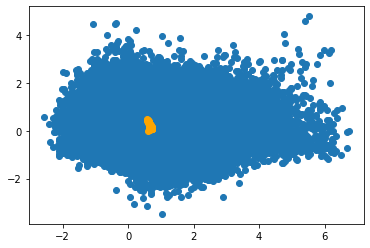

In [112]:
plt.scatter(pca[:, 0], pca[:, 1])
for w in diff_words:
    ind = enumerated_words.index(w)
    plt.scatter(pca[ind, 0], pca[ind, 1], color='orange')
ax.set_xticks([])
ax.set_yticks([])

## Try SenticNet

In [1]:
from senticnet.senticnet import SenticNet

In [3]:
sn = SenticNet()
sn

In [8]:
sn.concept('fragile')

{'polarity_label': 'negative',
 'polarity_value': '-0.81',
 'sentics': {'introspection': '-0.78',
  'temper': '-0.84',
  'attitude': '0',
  'sensitivity': '0'},
 'moodtags': ['#sadness', '#anger'],
 'semantics': ['economy', 'economy_class', 'cheap', 'bad_quality', 'shit']}

## Embedding Sentiment space

In [3]:
from gensim.models import Word2Vec
import gensim.downloader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [2]:
w2v = gensim.downloader.load('word2vec-google-news-300')

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=-------------------------------------------------] 3.3% 54.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 5.1% 85.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===-----------------------------------------------] 7.0% 116.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 8.9% 147.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 10.7% 178.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 12.6% 209.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.5% 240.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 16.3% 271.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 19.9% 331.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 23.4% 388.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 25.2% 419.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 29.3% 486.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 31.7% 527.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.7% 592.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 37.5% 623.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 41.8% 695.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 45.4% 754.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 47.4% 788.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 51.7% 860.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 53.5% 890.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 57.8% 961.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 62.0% 1031.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.4% 1087.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.6% 1140.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================================---------------] 70.4% 1170.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================================-------------] 74.3% 1236.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 78.3% 1302.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================================----------] 81.0% 1346.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.5% 1405.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================================-------] 87.3% 1450.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 89.7% 1491.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.5% 1554.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================================--] 97.4% 1619.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 99.1% 1648.4/1662.8MB downloaded


In [51]:
#words = ['gorgeous', 'disgusting', 'happy', 'sad']
words = ['gorgeous', 'ugly']
words = ['excellent', 'poor']
features = np.stack([w2v.get_vector(w) for w in words])

In [54]:
w2v.most_similar('excellent')

[('terrific', 0.7409728765487671),
 ('superb', 0.7062715888023376),
 ('exceptional', 0.681470513343811),
 ('fantastic', 0.6802847385406494),
 ('good', 0.644292950630188),
 ('great', 0.6124600172042847),
 ('Excellent', 0.6091997623443604),
 ('impeccable', 0.5980967283248901),
 ('exemplary', 0.5959650278091431),
 ('marvelous', 0.582928478717804)]

In [52]:
dim = 1
pca = PCA(n_components=dim)
pca_result = pca.fit_transform(features)
pca_result

array([[ 1.4173217],
       [-1.4173211]], dtype=float32)

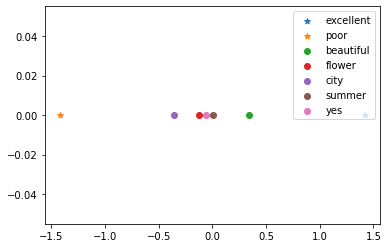

In [53]:
for i, word in enumerate(words):
    plt.scatter(pca_result[i, 0], 0 if dim==1 else pca_result[i, 1], label=word, marker='*')
test_words = ['beautiful', 'flower', 'city', 'summer', 'yes']
test = pca.transform(np.stack([w2v.get_vector(w) for w in test_words]))
for i, word in enumerate(test_words):
    plt.scatter(test[i, 0], 0 if dim==1 else test[i, 1], label=word)
plt.legend()

## Elphi dependency based approach

In [38]:
import spacy
import re
nlp = spacy.load("en")

In [50]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7f45c42abb50>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f45e688e340>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f45c4354be0>)]

In [54]:
for x in nlp('This is a sentece. And this is another one'):
    print(x.is_sent_start)

True
None
None
None
None
True
None
None
None
None


In [51]:
nlp_de = spacy.load('de')
nlp_de.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7f45b4202d30>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f45b4420ee0>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f45b4420f40>)]

In [96]:
doc = nlp('View on the beautiful Elbphilharmonie in Hamburg')
parsed = {t.text: (i, list(t.children)) for i, t in enumerate(doc)}
print(parsed)
list(doc[parsed['Elbphilharmonie'][0]].subtree)

{'View': (0, [on]), 'on': (1, [Elbphilharmonie]), 'the': (2, []), 'beautiful': (3, []), 'Elbphilharmonie': (4, [the, beautiful, in]), 'in': (5, [Hamburg]), 'Hamburg': (6, [])}


[the, beautiful, Elbphilharmonie, in, Hamburg]

In [62]:
doc = nlp('Hamburg\'s Elbphilharmonie is simply a waste of money.')
parsed = {t.text: (i, list(t.children)) for i, t in enumerate(doc)}
print(parsed)
list(doc[parsed['Elbphilharmonie'][0]].subtree)

{'Hamburg': (0, ['s]), "'s": (1, []), 'Elbphilharmonie': (2, [Hamburg]), 'is': (3, [Elbphilharmonie, simply, waste, .]), 'simply': (4, []), 'a': (5, []), 'waste': (6, [a, of]), 'of': (7, [money]), 'money': (8, []), '.': (9, [])}


[Hamburg, 's, Elbphilharmonie]

In [ ]:
doc = nlp('Two Hamburg Icons MS Cap San Diego and the Elbphilharmonie Opera House. While the one is retired and cruises just once a year on the Elbe, the other is not even being finished.')
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

In [97]:
#spacy.displacy.render(doc, style='dep', options={'collapse_phrases':True, 'offset_x': 100})
options = {'compact':False, 'offset_x': 30, 'word_spacing':30, 'distance':110, 'arrow_width': 8}
spacy.displacy.render(doc, style='dep', options=options)

In [98]:
from pathlib import Path
#svg = spacy.displacy.render(doc, style='dep', jupyter=False)
svg = spacy.displacy.render(doc, style='dep', options=options, jupyter=False)
output_path = Path("scraping/test_data_evaluation/dep_parsing_2_export.svg")
output_path.open("w", encoding="utf-8").write(svg)

5532

In [144]:
type(nlp)

spacy.lang.en.English

In [29]:
len(df[df.Message_en.str.contains('(E|e)lbphilharmonie|Elphi')])/len(df)

0.6391304347826087

In [49]:
for m in df[~df.Message_en.str.contains(r'(E|e)lbe?phil?h?ar?monie|(e|E)lphi|(E|e)lbphilharmony')].Message_en:
    print(m)

IMG_6518.jpg
  
 winter
DSCF3821
  
 #Hamburg
Hamburg
 Impressions from Hamburg -
 #hamburg # 2015 #giant photos
DSC03381
  
 #germany #deutschland #hamburg #germany #hamburg #germany
.
 .
 
 #germany #deutschland #hamburg #germany #hamburg #germany
Speicherstadt HH
  
 #water #hamburg #autumn #hafen # cities #elbe
IMG_6537.jpg
  
 Germany
IMG_4915 
  
 #city #germany #hamburg #chanell
Hamburg 32 
 The 110 meter high Elbe Philharmonic Hall. 
 #hamburg
Concertgebouw 
 Hamburg 
 #city #travel #building #architecture #germany #europe #hamburg
Hamburg harbor
  
 #Hamburg
DSC_0510 
  
 #building #hamburg
sw_DSCF3781 
  
 #hamburg #landscape #architecture
I was freezing... 
 Opera House, Hamburg 
 #architecture #germany #hamburg #operahouse
DSCF4604 
  
 #hamburg #speicherstadt #port #architecture #brick #building #glas #sea #water
Hamburg
  
 #Hamburg
#hamburg
IMG_7750
  
 #deutschland #hamburg #hafen # 2016 #guidokpunkt
HH Außenalster und Speicherstadt
  
 #hamburg #olympus #speicherstadt 

In [42]:
re.match(r'(E|e)lbphilh?armonie', "Elbphilarmonie")

<re.Match object; span=(0, 14), match='Elbphilarmonie'>

In [141]:
elphis = df[df.Message_en.str.contains('Elbphilharmonie')].Message_en
elphis = elphis.apply(lambda x: re.sub(' \n', '',x))
elphis = elphis.apply(lambda x: re.sub('  ', ' ',x))
elphis = elphis.apply(lambda x: re.sub('#', '',x))
for r in elphis[2:3]:
    print(r)
    doc = nlp(r)
    spacy.displacy.render(doc, style='dep')
    for sent in doc.sents:
        parsed = {t.text.lower(): (i, t.children) for i, t in enumerate(sent)}
        print(parsed)
        if 'elbphilharmonie' in parsed:
            print(list(sent[parsed['elbphilharmonie'][0]].subtree))

Two Hamburg Icons MS Cap San Diego and the Elbphilharmonie / Opera House. While the one is retired and cruises just once a year on the Elbe, the other is not even being finished. Opening planned for 2017. germany nikon ship harbour hamburg hafen d800 70200mm capsandiego elbphilharmonie


{'two': (0, <generator object at 0x7ffe1cc60370>), 'hamburg': (1, <generator object at 0x7ffe1cc602d0>), 'icons': (2, <generator object at 0x7ffe1cc60230>), 'ms': (3, <generator object at 0x7ffe1cc60190>), 'cap': (4, <generator object at 0x7ffe1cc600f0>), 'san': (5, <generator object at 0x7ffe1cc60050>), 'diego': (6, <generator object at 0x7ffe1cc432d0>), 'and': (7, <generator object at 0x7ffe1cc43370>), 'the': (8, <generator object at 0x7ffe1cc435f0>), 'elbphilharmonie': (9, <generator object at 0x7ffe1cc43410>), '/': (10, <generator object at 0x7ffe1cc43190>), 'opera': (11, <generator object at 0x7ffe1cc43870>), 'house': (12, <generator object at 0x7ffe1cc43a50>), '.': (13, <generator object at 0x7ffe1cc43b90>)}
[Elbphilharmonie]
{'while': (0, <generator object at 0x7ffe1cc43eb0>), 'the': (15, <generator object at 0x7ffe39c90cd0>), 'one': (2, <generator object at 0x7ffe1ccecb90>), 'is': (17, <generator object at 0x7ffe39c909b0>), 'retired': (4, <generator object at 0x7ffe1ccecd70>), 

In [127]:
df[df.Message_en.str.contains('Elbphilharmonie')].Message_en.apply(lambda x: re.sub(' \n', '',x))

0       Elbphilharmonie  #germany #germany #harbor #ha...
2       Hamburg Elbphilharmonie  View on the Elbphilha...
3       Two Hamburg Icons  MS Cap San Diego and the El...
12      The Elbphilharmonie in the fog In the old and ...
15      Harbor tour HH (06 of 07) Elbphilharmonie (2) ...
                              ...                        
2970    Hamburg 2019 Elbphilharmonie #hamburg #elbphil...
2972    Elbphilharmonie  #hamburg #architecture #elbe ...
2973    Elbphilharmonie  #hamburg #architecture #elbe ...
2986    Elbphilharmonie Elbphilharmonie at dusk #elbph...
2987    Hamburg0042Elbphilharmonie  #hamburg #germany ...
Name: Message_en, Length: 1222, dtype: object

## Coreference resolution with AllenNLP

In [11]:
from allennlp.predictors.predictor import Predictor
from allennlp.models.archival import load_archive
import allennlp
allennlp.common.plugins.import_plugins()

In [ ]:
#model_url = 'https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz'
#model_path = 'coref-spanbert-large-2020.02.27.tar.gz'
#ar = load_archive(model_path)
predictor = Predictor.from_path(model_url, predictor_name='test', include_package=True)  # load the model

text = "Two Hamburg Icons MS Cap San Diego and the Elbphilharmonie / Opera House. While the one is retired and cruises just once a year on the Elbe, the other is not even being finished."
prediction = predictor.predict(document=text)
prediction

In [15]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging

predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2021.03.10.tar.gz")
predictor.predict(
    document="Paul Allen was born on January 21, 1953, in Seattle, Washington, to Kenneth Sam Allen and Edna Faye Allen. Allen attended Lakeside School, a private school in Seattle, where he befriended Bill Gates, two years younger, with whom he shared an enthusiasm for computers."
)

2021-10-19 09:38:33,025 - INFO - allennlp.common.plugins - Plugin allennlp_models available
2021-10-19 09:38:33,252 - INFO - allennlp.common.file_utils - https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2021.03.10.tar.gz not found in cache, downloading to /home/anschutzm/.allennlp/cache/038f918d294bd1a45e3709dfb22af5277b0be8677f750a85748c39979ce0e549.b897bfe76a04a5f70d6e88762a4d819b4b8b90e45b31b8314e0a6a9630d3f213


downloading:   0%|          | 0/1345986155 [00:00<?, ?B/s]

2021-10-19 09:39:44,553 - INFO - allennlp.models.archival - loading archive file https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2021.03.10.tar.gz from cache at /home/anschutzm/.allennlp/cache/038f918d294bd1a45e3709dfb22af5277b0be8677f750a85748c39979ce0e549.b897bfe76a04a5f70d6e88762a4d819b4b8b90e45b31b8314e0a6a9630d3f213
2021-10-19 09:39:44,554 - INFO - allennlp.models.archival - extracting archive file /home/anschutzm/.allennlp/cache/038f918d294bd1a45e3709dfb22af5277b0be8677f750a85748c39979ce0e549.b897bfe76a04a5f70d6e88762a4d819b4b8b90e45b31b8314e0a6a9630d3f213 to temp dir /tmp/tmpac4dbmyo
2021-10-19 09:39:55,902 - INFO - allennlp.common.params - dataset_reader.type = coref
2021-10-19 09:39:55,903 - INFO - allennlp.common.params - dataset_reader.max_instances = None
2021-10-19 09:39:55,903 - INFO - allennlp.common.params - dataset_reader.manual_distributed_sharding = False
2021-10-19 09:39:55,904 - INFO - allennlp.common.params - dataset_reader.manual_multip

Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

2021-10-19 09:40:10,734 - INFO - allennlp.common.params - dataset_reader.wordpiece_modeling_tokenizer = None
2021-10-19 09:40:10,741 - INFO - allennlp.common.params - dataset_reader.max_sentences = 110
2021-10-19 09:40:10,746 - INFO - allennlp.common.params - dataset_reader.remove_singleton_clusters = False
2021-10-19 09:40:10,757 - INFO - allennlp.common.params - validation_dataset_reader.type = coref
2021-10-19 09:40:10,762 - INFO - allennlp.common.params - validation_dataset_reader.max_instances = None
2021-10-19 09:40:10,777 - INFO - allennlp.common.params - validation_dataset_reader.manual_distributed_sharding = False
2021-10-19 09:40:10,783 - INFO - allennlp.common.params - validation_dataset_reader.manual_multiprocess_sharding = False
2021-10-19 09:40:10,789 - INFO - allennlp.common.params - validation_dataset_reader.max_span_width = 30
2021-10-19 09:40:10,805 - INFO - allennlp.common.params - validation_dataset_reader.token_indexers.type = ref
2021-10-19 09:40:10,821 - INFO - a

Downloading:   0%|          | 0.00/665M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2021-10-19 09:40:53,402 - INFO - allennlp.common.params - model.context_layer.type = pass_through
2021-10-19 09:40:53,403 - INFO - allennlp.common.params - model.context_layer.type = pass_through
2021-10-19 09:40:53,404 - INFO - allennlp.common.params - model.context_layer.input_dim = 1024
2021-10-19 09:40:53,405 - INFO - allennlp.common.params - model.mention_feedforward.type = ref
2021-10-19 09:40:53,409 - INFO - allennlp.common.params - model.mention_feedforward.input_dim = 3092
2021-10-19 09:40:53,412 - INFO - allennlp.common.params - model.mention_feedforward.num_layers = 2
2021-10-19 09:40:53,413 - INFO - allennlp.common.params - model.mention_feedforward.hidden_dims = 1500
2021-10-19 0

2021-10-19 09:40:53,873 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.0.intermediate.dense.weight
2021-10-19 09:40:53,874 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.0.output.LayerNorm.bias
2021-10-19 09:40:53,875 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.0.output.LayerNorm.weight
2021-10-19 09:40:53,877 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.0.output.dense.bias
2021-10-19 09:40:53,879 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.0.output.dense.weight
2021-10-19 09:40:53,881 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_t

2021-10-19 09:40:54,014 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.11.attention.self.value.bias
2021-10-19 09:40:54,015 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.11.attention.self.value.weight
2021-10-19 09:40:54,017 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.11.intermediate.dense.bias
2021-10-19 09:40:54,019 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.11.intermediate.dense.weight
2021-10-19 09:40:54,020 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.11.output.LayerNorm.bias
2021-10-19 09:40:54,021 - INFO - allennlp.nn.initializers -    _text_field_embe

2021-10-19 09:40:54,091 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.14.attention.self.key.weight
2021-10-19 09:40:54,092 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.14.attention.self.query.bias
2021-10-19 09:40:54,093 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.14.attention.self.query.weight
2021-10-19 09:40:54,095 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.14.attention.self.value.bias
2021-10-19 09:40:54,095 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.14.attention.self.value.weight
2021-10-19 09:40:54,096 - INFO - allennlp.nn.initializers -    _text_fi

2021-10-19 09:40:54,153 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.17.attention.output.dense.bias
2021-10-19 09:40:54,155 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.17.attention.output.dense.weight
2021-10-19 09:40:54,156 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.17.attention.self.key.bias
2021-10-19 09:40:54,158 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.17.attention.self.key.weight
2021-10-19 09:40:54,159 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.17.attention.self.query.bias
2021-10-19 09:40:54,160 - INFO - allennlp.nn.initializers -    _text_fi

2021-10-19 09:40:54,312 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.19.output.dense.weight
2021-10-19 09:40:54,313 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.2.attention.output.LayerNorm.bias
2021-10-19 09:40:54,316 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.2.attention.output.LayerNorm.weight
2021-10-19 09:40:54,318 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.2.attention.output.dense.bias
2021-10-19 09:40:54,319 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.2.attention.output.dense.weight
2021-10-19 09:40:54,321 - INFO - allennlp.nn.initializers -    _t

2021-10-19 09:40:54,431 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.21.output.LayerNorm.bias
2021-10-19 09:40:54,432 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.21.output.LayerNorm.weight
2021-10-19 09:40:54,434 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.21.output.dense.bias
2021-10-19 09:40:54,436 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.21.output.dense.weight
2021-10-19 09:40:54,438 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.22.attention.output.LayerNorm.bias
2021-10-19 09:40:54,441 - INFO - allennlp.nn.initializers -    _text_field_embedder.token

2021-10-19 09:40:54,531 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.3.attention.self.value.weight
2021-10-19 09:40:54,534 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.3.intermediate.dense.bias
2021-10-19 09:40:54,535 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.3.intermediate.dense.weight
2021-10-19 09:40:54,536 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.3.output.LayerNorm.bias
2021-10-19 09:40:54,537 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.3.output.LayerNorm.weight
2021-10-19 09:40:54,538 - INFO - allennlp.nn.initializers -    _text_field_embedder.to

2021-10-19 09:40:54,595 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.6.attention.self.query.bias
2021-10-19 09:40:54,596 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.6.attention.self.query.weight
2021-10-19 09:40:54,597 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.6.attention.self.value.bias
2021-10-19 09:40:54,600 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.6.attention.self.value.weight
2021-10-19 09:40:54,603 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.6.intermediate.dense.bias
2021-10-19 09:40:54,607 - INFO - allennlp.nn.initializers -    _text_field_emb

2021-10-19 09:40:54,701 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.9.attention.output.dense.weight
2021-10-19 09:40:54,704 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.9.attention.self.key.bias
2021-10-19 09:40:54,705 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.9.attention.self.key.weight
2021-10-19 09:40:54,707 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.9.attention.self.query.bias
2021-10-19 09:40:54,708 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.9.attention.self.query.weight
2021-10-19 09:40:54,710 - INFO - allennlp.nn.initializers -    _text_field_e

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=6bd657a99216aad51f5d2d5feb71a0b0323e2b800159723815b5da0f4bf6eab2
  Stored in directory: /tmp/pip-ephem-wheel-cache-y7dbiaqb/wheels/19/d6/1c/5484b95647df5d7afaf74abde458c66c1cd427e69e801fe826
Successfully built en-core-web-sm


You should consider upgrading via the '/home/anschutzm/Dokumente/TUM/MA/.naacl_venv/bin/python3 -m pip install --upgrade pip' command.


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


{'top_spans': [[0, 1],
  [3, 3],
  [5, 8],
  [5, 14],
  [8, 8],
  [11, 13],
  [11, 14],
  [13, 13],
  [16, 18],
  [16, 22],
  [20, 22],
  [24, 24],
  [26, 52],
  [33, 33],
  [36, 36],
  [37, 37],
  [38, 52],
  [41, 42],
  [47, 47],
  [48, 48],
  [49, 52]],
 'antecedent_indices': [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

In [99]:
text = "The Elbphilharmonie is a building in Hamburg. It is beautiful."
text = 'Two Hamburg Icons: MS Cap San Diego and the Elbphilharmonie. While one is retired, the other one is not even being finished.'
# text = 'The Elbphilharmonie (also English: Elbe Philharmonic Hall) is a concert hall in the HafenCity quarter of Hamburg, Germany, on the Grasbrook peninsula of the Elbe River. It is one of the largest and most acoustically advanced concert halls in the world. It is popularly nicknamed Elphi.'
text = 'Two Hamburg Icons MS Cap San Diego and the Elbphilharmonie Opera House. While the one is retired and cruises just once a year on the Elbe, the other is not even being finished.'
prediction = predictor.predict(document=text)
prediction

{'top_spans': [[0, 2],
  [0, 6],
  [0, 11],
  [1, 1],
  [3, 6],
  [3, 11],
  [8, 11],
  [14, 15],
  [17, 17],
  [19, 19],
  [22, 22],
  [22, 23],
  [25, 26],
  [28, 29]],
 'antecedent_indices': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]],
 'predicted_antecedents': [-1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -

## VADER sentiment dict

In [100]:
import pandas as pd

In [105]:
senti_df = pd.read_csv('vader_lexicon.txt', sep='\t', names=['Token', 'Sentiment', 'standard_deviation', 'raw_ratings'])
senti_dict = {r.Token: r.Sentiment for _, r in senti_df.iterrows()}
senti_dict

{'$:': -1.5,
 '%)': -0.4,
 '%-)': -1.5,
 '&-:': -0.4,
 '&:': -0.7,
 "( '}{' )": 1.6,
 '(%': -0.9,
 "('-:": 2.2,
 "(':": 2.3,
 '((-:': 2.1,
 '(*': 1.1,
 '(-%': -0.7,
 '(-*': 1.3,
 '(-:': 1.6,
 '(-:0': 2.8,
 '(-:<': -0.4,
 '(-:o': 1.5,
 '(-:O': 1.5,
 '(-:{': -0.1,
 '(-:|>*': 1.9,
 '(-;': 1.3,
 '(-;|': 2.1,
 '(8': 2.6,
 '(:': 2.2,
 '(:0': 2.4,
 '(:<': -0.2,
 '(:o': 2.5,
 '(:O': 2.5,
 '(;': 1.1,
 '(;<': 0.3,
 '(=': 2.2,
 '(?:': 2.1,
 '(^:': 1.5,
 '(^;': 1.5,
 '(^;0': 2.0,
 '(^;o': 1.9,
 '(o:': 1.6,
 ")':": -2.0,
 ")-':": -2.1,
 ')-:': -2.1,
 ')-:<': -2.2,
 ')-:{': -2.1,
 '):': -1.8,
 '):<': -1.9,
 '):{': -2.3,
 ');<': -2.6,
 '*)': 0.6,
 '*-)': 0.3,
 '*-:': 2.1,
 '*-;': 2.4,
 '*:': 1.9,
 '*<|:-)': 1.6,
 '*\\0/*': 2.3,
 '*^:': 1.6,
 ',-:': 1.2,
 "---'-;-{@": 2.3,
 '--<--<@': 2.2,
 '.-:': -1.2,
 '..###-:': -1.7,
 '..###:': -1.9,
 '/-:': -1.3,
 '/:': -1.3,
 '/:<': -1.4,
 '/=': -0.9,
 '/^:': -1.0,
 '/o:': -1.4,
 '0-8': 0.1,
 '0-|': -1.2,
 '0:)': 1.9,
 '0:-)': 1.4,
 '0:-3': 1.5,
 '0:03': 1.9,
 '

In [145]:
senti_dict['old']

KeyError: 'old'

In [117]:
len(senti_dict)

7506

In [163]:
def print_sentiment_words(sent, sent_dict):
    for word in sent.split(' '):
        if '#' in word:
            word = word[1:]
        if word in sent_dict:
            print(word, sent_dict[word])
sent = 'Das komische Wellendach der Elbphilharmonie passt nicht ins Bild der historischen Altstadt. #verunstaltung #modern #hässlich'
#sent = 'Fototour mit Elke in der HafenCity bei bestem Wetter :-)'
print_sentiment_words(sent, ger_senti_dict)
print()
sent = 'The new opera of Hamburg called "Elbphilharmonie"; built on an old storage building in the seaport. #opera #hamburg #philharmonie'
sent = 'View on the beautiful Elbphilharmonie in Hamburg'
sent = 'Hamburg’s Elbphilharmonie is simply a waste of money'
sent = 'The weird wave roof of the Elbphilharmonie does not fit into the image of the historic old town. #defacement #modern #ugly'
print_sentiment_words(sent, senti_dict)

historischen 0.6
modern 1.9
hässlich -2.5

weird -0.7
fit 1.5
ugly -2.3


In [121]:
ger_senti_df = pd.read_csv('GERVaderLexicon.txt', sep='\t', names=['Token', 'Sentiment', 'standard_deviation', 'raw_ratings'])
ger_senti_dict = {r.Token: r.Sentiment for _, r in ger_senti_df.iterrows()}
ger_senti_dict

{'$:': -1.5,
 '%)': -0.4,
 '%-)': -1.5,
 '&-:': -0.4,
 '&:': -0.7,
 "( '}{' )": 1.6,
 '(%': -0.9,
 "('-:": 2.2,
 "(':": 2.3,
 '((-:': 2.1,
 '(*': 1.1,
 '(-%': -0.7,
 '(-*': 1.3,
 '(-:': 1.6,
 '(-:0': 2.8,
 '(-:<': -0.4,
 '(-:o': 1.5,
 '(-:O': 1.5,
 '(-:{': -0.1,
 '(-:|>*': 1.9,
 '(-;': 1.3,
 '(-;|': 2.1,
 '(8': 2.6,
 '(:': 2.2,
 '(:0': 2.4,
 '(:<': -0.2,
 '(:o': 2.5,
 '(:O': 2.5,
 '(;': 1.1,
 '(;<': 0.3,
 '(=': 2.2,
 '(?:': 2.1,
 '(^:': 1.5,
 '(^;': 1.5,
 '(^;0': 2.0,
 '(^;o': 1.9,
 '(o:': 1.6,
 ")':": -2.0,
 ")-':": -2.1,
 ')-:': -2.1,
 ')-:<': -2.2,
 ')-:{': -2.1,
 '):': -1.8,
 '):<': -1.9,
 '):{': -2.3,
 ');<': -2.6,
 '*)': 0.6,
 '*-)': 0.3,
 '*-:': 2.1,
 '*-;': 2.4,
 '*:': 1.9,
 '*<|:-)': 1.6,
 '*\\0/*': 2.3,
 '*^:': 1.6,
 ',-:': 1.2,
 "---'-;-{@": 2.3,
 '--<--<@': 2.2,
 '.-:': -1.2,
 '..###-:': -1.7,
 '..###:': -1.9,
 '/-:': -1.3,
 '/:': -1.3,
 '/:<': -1.4,
 '/=': -0.9,
 '/^:': -1.0,
 '/o:': -1.4,
 '0-8': 0.1,
 '0-|': -1.2,
 '0:)': 1.9,
 '0:-)': 1.4,
 '0:-3': 1.5,
 '0:03': 1.9,
 '

In [139]:
ger_senti_dict['potthässlich']

KeyError: 'potthässlich'

In [122]:
len(ger_senti_dict)

34585

In [123]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/anschutzm/nltk_data...


In [129]:
dir(sid)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_amplify_ep',
 '_amplify_qm',
 '_but_check',
 '_idioms_check',
 '_least_check',
 '_never_check',
 '_punctuation_emphasis',
 '_sift_sentiment_scores',
 'lexicon',
 'lexicon_file',
 'make_lex_dict',
 'polarity_scores',
 'score_valence',
 'sentiment_valence']

In [152]:
sid.polarity_scores('The weird wave roof of the Elbphilharmonie does not fit into the image of the historic old town. #defacement #modern #ugly')

{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'compound': -0.4234}

In [141]:
len(sid.make_lex_dict())

7502